## Task 2: Comparing the performance of different pretrained models

In [ ]:
!pip install -U d2l

In [3]:
%matplotlib inline
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from d2l import torch as d2l

In [4]:
transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Resize(224),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#validation and training set
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#download 10000 testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

num_classes = 10

#split 50k dataset into train and validation
train_size = int(0.7 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
#load test dataset
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=128, 
                                        shuffle=True, num_workers = 4)

In [6]:
#initialise model and reshape final layer
#ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def initialize_model(model_name, num_classes=10, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = torchvision.models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.fc.weight);

    elif model_name == "alexnet":
        """ Alexnet
        """
        print("alexnet")
        model_ft = torchvision.models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.classifier[6].weight);

    elif model_name == "vgg":
        """ VGG16
        """
        print("vgg")
        model_ft = torchvision.models.vgg16(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.classifier[6].weight);
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [7]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(model_name, net, learning_rate, batch_size=128, num_epochs=10,
                      param_group=True):
    #load training dataset
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
    #load validation dataset
    val_iter = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss()
    if param_group:
        if model_name=="resnet":
            params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
            trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
        else:
            params_1x = [param for name, param in net.named_parameters()
                if name not in ["classifier.6.weight", "classifier.6.bias"]]
            trainer = torch.optim.SGD([{'params': params_1x},
                                    {'params': net.classifier[6].parameters(),
                                        'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, val_iter, loss, trainer, num_epochs,
                   devices)

### VGG
#### Fine tuned

loss 0.000, train acc 0.982, test acc 0.925
52.9 examples/sec on [device(type='cuda', index=0)]


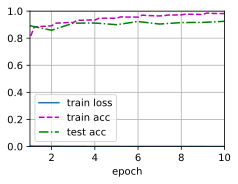

In [ ]:
#finetune_net = initialize_model("resnet")
#train_fine_tuning("resnet", finetune_net, 5e-5)
net = initialize_model("vgg")
train_fine_tuning("vgg", net, 5e-3)

In [ ]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.9193

#### Scratch

loss 0.005, train acc 0.781, test acc 0.695
52.9 examples/sec on [device(type='cuda', index=0)]


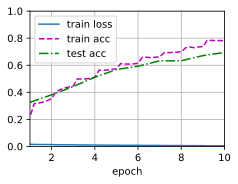

In [ ]:
net = initialize_model("vgg", use_pretrained=False)
train_fine_tuning("vgg", net, 5e-2, param_group=False)

In [ ]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.6929

### Resnet
#### Fine tuned

loss 0.000, train acc 0.998, test acc 0.935
295.0 examples/sec on [device(type='cuda', index=0)]


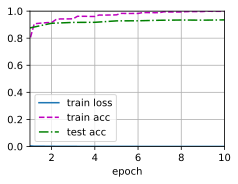

In [ ]:
net = initialize_model("resnet")
train_fine_tuning("resnet", net, 5e-3)

In [ ]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.932

#### Scratch

loss 0.000, train acc 0.996, test acc 0.576
294.6 examples/sec on [device(type='cuda', index=0)]


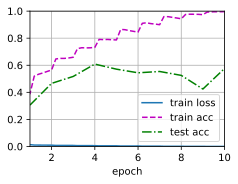

In [ ]:
net = initialize_model("resnet", use_pretrained=False)
train_fine_tuning("resnet", net, 5e-2, param_group=False)

In [ ]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.5833

### AlexNet
#### Fine tuned

loss 0.005, train acc 0.755, test acc 0.785
1249.6 examples/sec on [device(type='cuda', index=0)]


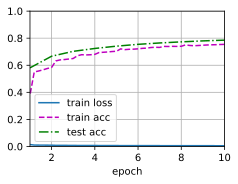

In [ ]:
net = initialize_model("alexnet")
train_fine_tuning("alexnet", net, 5e-5)

In [ ]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.7885



*   fast
*   good results
* can be better with learning rate adjustments



loss 0.001, train acc 0.932, test acc 0.879
1692.6 examples/sec on [device(type='cuda', index=0)]


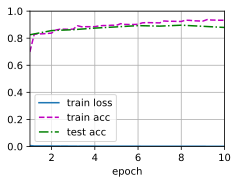

In [8]:
net = initialize_model("alexnet")
train_fine_tuning("alexnet", net, 5e-3)

In [9]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.876

* better
* can be better with greater learning rate

loss nan, train acc 0.098, test acc 0.104
1705.6 examples/sec on [device(type='cuda', index=0)]


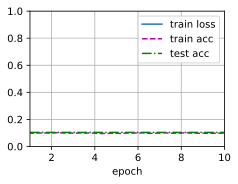

In [11]:
net = initialize_model("alexnet")
train_fine_tuning("alexnet", net, 5e-2)

In [12]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.1

* completely worse results after moving 1 decimal point

loss 0.003, train acc 0.887, test acc 0.877
1694.7 examples/sec on [device(type='cuda', index=0)]


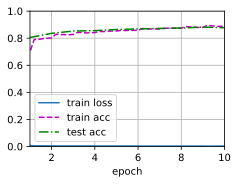

In [13]:
net = initialize_model("alexnet")
train_fine_tuning("alexnet", net, 1e-3)

In [14]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.8787

#### Scratch

loss 0.018, train acc 0.118, test acc 0.136
1242.8 examples/sec on [device(type='cuda', index=0)]


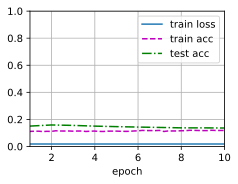

In [ ]:
net = initialize_model("alexnet", use_pretrained=False)
train_fine_tuning("alexnet", net, 5e-4, param_group=False)

In [ ]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.1361